In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from typing import Callable, Literal
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

import jaxtyping

In [43]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("../scripts").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from model import Tree, Config, Model, construct_tree, Node
import utils_updated as utils

from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
    plot_features_in_2d_hierarchy_labeled
)
# import part4_superposition_and_saes.tests as tests
# import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

current PyTorch install was built with MPS enabled.
MPS is available


# Functions

In [4]:
# plot the first instance as a bar chart for batch_data and model(batch_data)
import matplotlib.pyplot as plt

# Plot the first instance of batch_data
import plotly.graph_objects as go

def plot_batch_data(batch_data, model_output_data, tree, i):    # Get the list of tree paths
    tree_paths = tree.to_list()
    fig = go.Figure(data=[
        go.Scatter(
            x=tree_paths,
            y=batch_data[0, i].cpu().numpy(),
            mode='lines',
            name='Batch Data',
            hovertemplate='%{x}<br>%{y}'
        ),
        go.Scatter(
            x=tree_paths,
            y=model_output_data[0, i].detach().cpu().numpy(),
            mode='lines',
            name='Model Output',
            hovertemplate='%{x}<br>%{y}'
        )
    ])

    fig.update_layout(
        title='First Instance of Batch Data and Model Output',
        yaxis_title='Value',
        width=1200,
        height=600,
        legend_title='Data Source',
        xaxis=dict(
            showticklabels=False,
            title=None,
            hoverformat='%{x}'
        )
    )

    fig.show()

In [5]:
def get_index_from_path(path, tree):
    node_list = tree.to_list()
    return node_list.index(path)

def get_cosine_similarity(path1, path2, model):
    index1 = get_index_from_path(path1, model.cfg.tree)
    index2 = get_index_from_path(path2, model.cfg.tree)
    W = model.W.detach().cpu()
    return cos(W[:,:,index1], W[:,:,index2])

def get_cosine_similarity_dict(model, depth):
    cosine_similarities = {}
    for i in model.cfg.tree.to_list():
        # if i has children, get cosine similarity of i and its children
        current_depth = i.count(".") + 1
        if current_depth < depth:
            cosine_similarities[(i, i + ".0")] = {
                "similarity": get_cosine_similarity(i, i + ".0", model).mean().item(),
                "depth": current_depth
            }
            cosine_similarities[(i, i + ".1")] = {
                "similarity": get_cosine_similarity(i, i + ".1", model).mean().item(),
                "depth": current_depth
            }
    
    return cosine_similarities

In [6]:
def plot_cosine_similarity_dict(model_plot, depth):
    cosine_similarities = get_cosine_similarity_dict(model_plot, depth)
    ## plot cosine_similarities as a histogram
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    similarities = [data['similarity'] for data in cosine_similarities.values()]
    depths = [data['depth'] for data in cosine_similarities.values()]
    plt.scatter(depths, similarities, alpha=0.5)
    plt.title(f"Cosine Similarities vs Depth (n_hidden={model_plot.cfg.n_hidden})")
    plt.xlabel("Depth")
    plt.ylabel("Cosine Similarity")
    plt.ylim(-0.1, 1.0)  # Set y-axis range from -0.1 to 1.0
    # plt.colorbar(label="Depth")
    plt.show()
    return cosine_similarities

# Small Tree Examples

## Binary Tree

In [30]:
tree_2 = construct_tree(branching_factor = 2, depth = 2)

cfg = Config(
    n_instances = 6,
    tree = tree_2,
    n_hidden = 2,
    partial_paths = False,
    n_features = len(tree_2.to_list()),
    # sample_type = "level_equal"
)

model_2_2 = Model(
    cfg = cfg,
    device = device,
)
model_2_2.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

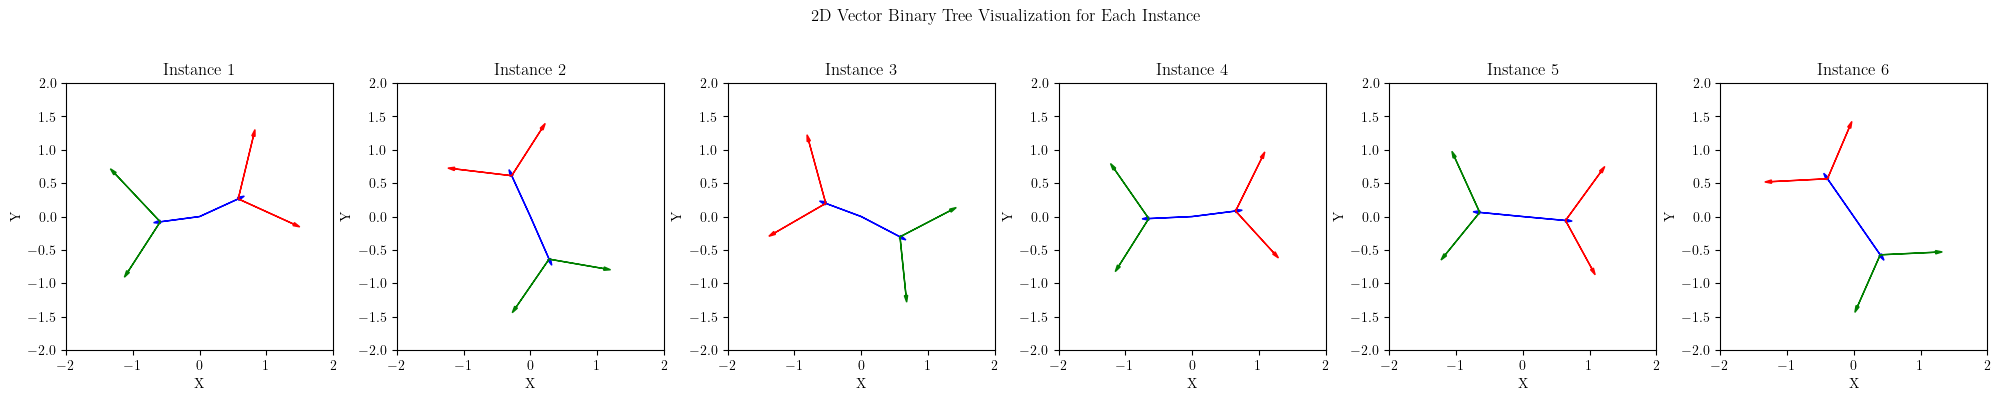

In [45]:
import torch
import plotly.graph_objects as go
import numpy as np

# Convert the tensor to numpy for easier handling
W_2d_np = model_2_2.W.detach().cpu().numpy()

# Create a figure with subplots for each instance
fig, axes = plt.subplots(1, model_2_2.cfg.n_instances, figsize=(20, 4))
fig.suptitle('2D Vector Binary Tree Visualization for Each Instance')

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(ax, start, end, color):
    ax.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1], 
             head_width=0.05, head_length=0.1, fc=color, ec=color)

for instance in range(model_2_2.cfg.n_instances):
    ax = axes[instance]
    
    # Plot level 1 (parent nodes)
    for i in [0, 3]:
        start = np.zeros(2)
        end = W_2d_np[instance, :, i]
        add_vector(ax, start, end, colors[0])

    # Plot level 2 (children of node 0)
    parent = W_2d_np[instance, :, 0]
    for i in range(1, 3):
        start = parent
        end = parent + W_2d_np[instance, :, i]
        add_vector(ax, start, end, colors[1])

    # Plot level 3 (children of node 1)
    parent = W_2d_np[instance, :, 3]
    for i in range(4, 6):
        start = parent
        end = parent + W_2d_np[instance, :, i]
        add_vector(ax, start, end, colors[2])

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title(f'Instance {instance+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

In [41]:
n_hidden = d_in = 2
n_features = d_sae = 6
n_inst = 6

# cfg = Config(n_inst=n_inst, n_features=n_features, d_hidden=d_hidden)
# model = Model(cfg=cfg, device=device)
# model.optimize(steps=10_000)
sae = SAE(cfg=SAEConfig(n_inst=n_inst, d_in=d_in, d_sae=d_sae), model=model_2_2)

h = sae.generate_batch(500)
data_log = sae.optimize(steps=25_000)


  0%|          | 0/25000 [00:00<?, ?it/s]

In [51]:
n_hidden = d_in = 2
n_features = d_sae = 4
n_inst = 6

sae = SAE(cfg=SAEConfig(n_inst=n_inst, d_in=d_in, d_sae=d_sae), model=model_2_2)

data_log = sae.optimize(steps=25_000, resample_method="simple")

utils.animate_features_in_2d(
    {
        "Encoder weights": t.stack(data_log["W_enc"]),
        "Decoder weights": t.stack(data_log["W_dec"]).transpose(-1, -2),
    },
    steps=data_log["steps"],
    filename="animation-resampling.html",
    title="SAE on toy model with simple resampling",
)


  0%|          | 0/25000 [00:00<?, ?it/s]

Saved animation at 'animation-resampling.html'


In [54]:
n_hidden = d_in = 2
n_features = d_sae = 4
n_inst = 6
l1_coeff = 0.0001
learning_rate = 5e-4

sae = SAE(cfg=SAEConfig(n_inst=n_inst, d_in=d_in, d_sae=d_sae, l1_coeff=l1_coeff), model=model_2_2)

data_log = sae.optimize(steps=25_000, resample_method="simple", lr = learning_rate)

utils.animate_features_in_2d(
    {
        "Encoder weights": t.stack(data_log["W_enc"]),
        "Decoder weights": t.stack(data_log["W_dec"]).transpose(-1, -2),
    },
    steps=data_log["steps"],
    filename=f"animation-resampling_l1_{l1_coeff}_lr_{learning_rate}.html",
    title="SAE on toy model with simple resampling",
)

  0%|          | 0/25000 [00:00<?, ?it/s]

Saved animation at 'animation-resampling_l1_0.0001_lr_0.0005.html'


In [69]:
instance_index = 1
h_unique =t.unique(h[:, instance_index, :].cpu(), dim=0)

In [77]:
h_cent = h_unique - sae.b_dec[instance_index].cpu()

acts = einops.einsum(
    h_cent, sae.W_enc[instance_index, ...].cpu(), "batch d_in, d_in d_sae -> batch d_sae"
)

acts = F.relu(acts + sae.b_enc[instance_index].cpu())

# Compute reconstructed input
h_reconstructed = (
    einops.einsum(
        acts, sae.W_dec[instance_index, ...].cpu(), "batch d_sae, d_sae d_in -> batch d_in"
    )
    + sae.b_dec[instance_index].cpu()
)

h_reconstructed = h_reconstructed.detach().numpy()

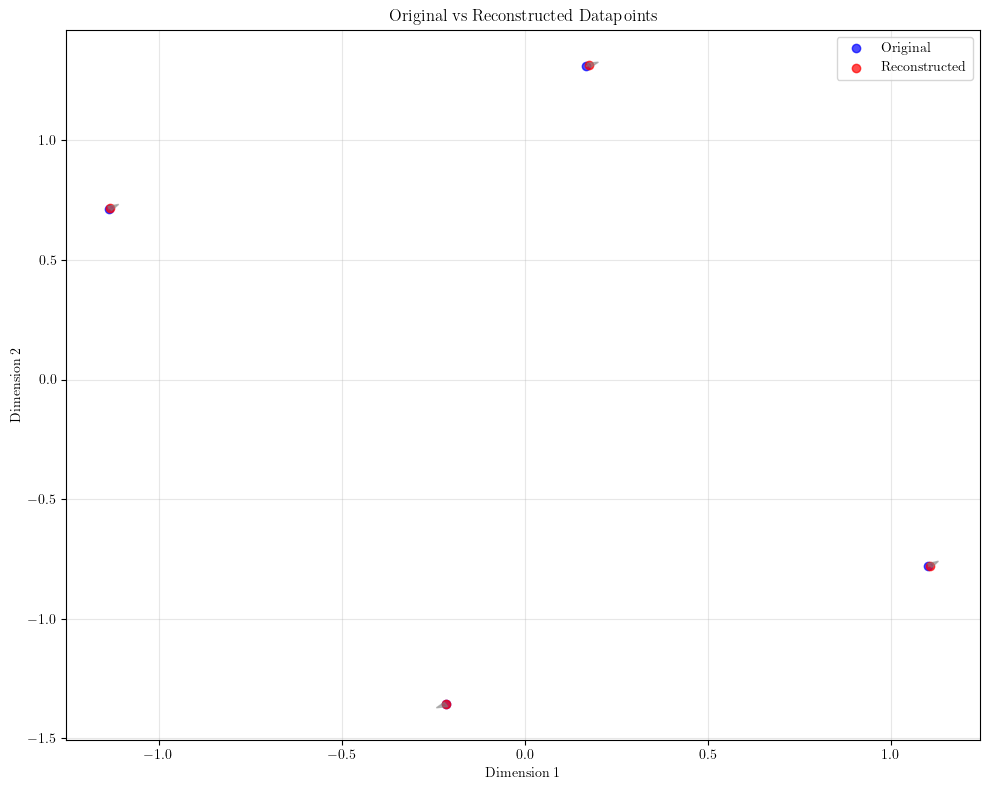

In [79]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot h_unique datapoints
plt.scatter(h_unique[:, 0], h_unique[:, 1], color='blue', label='Original', alpha=0.7)

# Plot h_reconstructed datapoints
plt.scatter(h_reconstructed[:, 0], h_reconstructed[:, 1], color='red', label='Reconstructed', alpha=0.7)

plt.title('Original vs Reconstructed Datapoints')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Add arrows to show the reconstruction direction
for i in range(len(h_unique)):
    plt.arrow(h_unique[i, 0], h_unique[i, 1], 
              h_reconstructed[i, 0] - h_unique[i, 0], 
              h_reconstructed[i, 1] - h_unique[i, 1], 
              color='gray', alpha=0.5, width=0.001, head_width=0.02)

plt.tight_layout()
plt.show()


In [ ]:
h_cent = h - self.b_dec

acts = einops.einsum(
    h_cent, self.W_enc, "batch inst d_in, inst d_in d_sae -> batch inst d_sae"
)
acts = F.relu(acts + self.b_enc)

# Compute reconstructed input
h_reconstructed = (
    einops.einsum(
        acts, self.W_dec, "batch inst d_sae, inst d_sae d_in -> batch inst d_in"
    )
    + self.b_dec
)

## Tree with two nodes, and only one of the nodes has five children

In [102]:
# Create a tree with two nodes, and only one of the nodes has five children
unique_tree = Node("root")

child1 = Node("child1")
child1.add_child(Node("grandchild1"))
child1.add_child(Node("grandchild2"))

unique_tree.add_child(child1)

node_with_children = Node("child2")
node_with_children.add_child(Node("grandchild1"))
node_with_children.add_child(Node("grandchild2"))
node_with_children.add_child(Node("grandchild3"))
node_with_children.add_child(Node("grandchild4"))
node_with_children.add_child(Node("grandchild5"))  # Added fifth child
unique_tree.add_child(node_with_children)

print(type(unique_tree))
unique_tree = Tree(unique_tree)
# Visualize the tree structure
print(unique_tree.to_list())


<class 'model.Node'>
['0', '0.0', '0.1', '1', '1.0', '1.1', '1.2', '1.3', '1.4']


In [104]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list()),
    sample_type = "level_equal"
)

model_unique_3_5_level = Model(
    cfg = cfg,
    device = device,
)
# model_unique_3_5_level.importance = t.tensor([5, 1, 1, 1, 1, 1, 1]).to(device)
model_unique_3_5_level.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [96]:
model_unique_3_5_level.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [107]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()
tree_list = unique_tree.to_list()

# Create a figure with subplots
fig = make_subplots(rows=1, cols=6, specs=[[{'type': 'scene'}]*6],
                    subplot_titles=[f'Instance {i+1}' for i in range(6)])

# Define colors for each level of the tree
colors = ['blue', 'green', 'red', 'orange']

# Function to add a vector to the plot
def add_vector(fig, row, col, start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ), row=row, col=col)
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ), row=row, col=col)

# Plot for each instance
for instance in range(6):
    # Plot level 1 (parent nodes)
    for i in ["0", "1"]:
        start = np.zeros(3)
        end = W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[int(i)])

    # Plot level 2 (children of node 0)
    parent = W_3d_np[instance, :, tree_list.index("0")]
    for i in ["0.0", "0.1"]:
        start = parent
        end = parent + W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[2])

    # Plot level 3 (children of node 1)
    parent = W_3d_np[instance, :, tree_list.index("1")]
    for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
        start = parent
        end = parent + W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[3])

    # Set layout for each subplot
    fig.update_scenes(
        xaxis_range=[-2, 2], yaxis_range=[-2, 2], zaxis_range=[-2, 2],
        aspectmode='cube',
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        row=1, col=instance+1
    )

# Update overall layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization for All Instances',
    height=600, width=3600,  # Increased width to accommodate all plots
    showlegend=False,  # Hide legend to save space
)

# Show the plot
fig.show()

In [109]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()
tree_list = unique_tree.to_list()

# Create a figure with a single subplot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]],
                    subplot_titles=['Instance 4'])

# Define colors for each level of the tree
colors = ['blue', 'green', 'red', 'orange']

# Function to add a vector to the plot
def add_vector(fig, row, col, start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ), row=row, col=col)
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ), row=row, col=col)

# Plot for instance 4
instance = 3  # Python uses 0-based indexing, so instance 4 is at index 3
# Plot level 1 (parent nodes)
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, 1, 1, start, end, f'Vector {i}', colors[int(i)])

# Plot level 2 (children of node 0)
parent = W_3d_np[instance, :, tree_list.index("0")]
for i in ["0.0", "0.1"]:
    start = parent
    end = parent + W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, 1, 1, start, end, f'Vector {i}', colors[2])

# Plot level 3 (children of node 1)
parent = W_3d_np[instance, :, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
    start = parent
    end = parent + W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, 1, 1, start, end, f'Vector {i}', colors[3])

# Set layout for the subplot
fig.update_scenes(
    xaxis_range=[-2, 2], yaxis_range=[-2, 2], zaxis_range=[-2, 2],
    aspectmode='cube',
    xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    row=1, col=1
)

# Update overall layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization for Instance 4',
    height=800, width=1000,
    showlegend=True,
)

# Show the plot
fig.show()

## run SAEs

In [48]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

@dataclass
class SAEConfig:
    n_inst: int
    d_in: int
    d_sae: int
    l1_coeff: float = 0.2
    weight_normalize_eps: float = 1e-8
    tied_weights: bool = False
    architecture: Literal["standard", "gated"] = "standard"


class SAE(nn.Module):
    W_enc: Float[Tensor, "inst d_in d_sae"]
    _W_dec: Float[Tensor, "inst d_sae d_in"] | None
    b_enc: Float[Tensor, "inst d_sae"]
    b_dec: Float[Tensor, "inst d_in"]

    def __init__(self, cfg: SAEConfig):
        super(SAE, self).__init__()

        # assert cfg.d_in == model.cfg.d_hidden, "Model's hidden dim doesn't match SAE input dim"
        assert cfg.d_in == model.cfg.n_hidden, "Model's hidden dim doesn't match SAE input dim"
        self.cfg = cfg
        self.model = model.requires_grad_(False)

        # YOUR CODE HERE
        raise NotImplementedError()

        self.to(device)

    @property
    def W_dec(self) -> Float[Tensor, "inst d_sae d_in"]:
        return self._W_dec if self._W_dec is not None else self.W_enc.transpose(-1, -2)

    @property
    def W_dec_normalized(self) -> Float[Tensor, "inst d_sae d_in"]:
        """Returns decoder weights, normalized over the autoencoder input dimension."""
        # YOUR CODE HERE
        raise NotImplementedError()

    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst d_in"]:
        """
        Generates a batch of hidden activations from our model.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(
        self,
        h: Float[Tensor, "batch inst d_in"],
    ) -> tuple[
        dict[str, Float[Tensor, "batch inst"]],
        Float[Tensor, ""],
        Float[Tensor, "batch inst d_sae"],
        Float[Tensor, "batch inst d_in"],
    ]:
        """
        Forward pass on the autoencoder.

        Args:
            h: hidden layer activations of model

        Returns:
            loss_dict: dict of different loss function term values, for every (batch elem, instance)
            loss: scalar total loss (summed over instances & averaged over batch dim)
            acts: autoencoder feature activations
            h_reconstructed: reconstructed autoencoder input
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        resample_method: Literal["simple", "advanced", None] = None,
        resample_freq: int = 2500,
        resample_window: int = 500,
        resample_scale: float = 0.5,
    ) -> dict[str, list]:
        """
        Optimizes the autoencoder using the given hyperparameters.

        Args:
            model:              we reconstruct features from model's hidden activations
            batch_size:         size of batches we pass through model & train autoencoder on
            steps:              number of optimization steps
            log_freq:           number of optimization steps between logging
            lr:                 learning rate
            lr_scale:           learning rate scaling function
            resample_method:    method for resampling dead latents
            resample_freq:      number of optimization steps between resampling dead latents
            resample_window:    number of steps needed for us to classify a neuron as dead
            resample_scale:     scale factor for resampled neurons

        Returns:
            data_log:               dictionary containing data we'll use for visualization
        """
        assert resample_window <= resample_freq

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr, betas=(0.0, 0.999))
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"steps": [], "W_enc": [], "W_dec": [], "frac_active": []}

        for step in progress_bar:
            # Resample dead latents
            if (resample_method is not None) and ((step + 1) % resample_freq == 0):
                frac_active_in_window = t.stack(frac_active_list[-resample_window:], dim=0)
                if resample_method == "simple":
                    self.resample_simple(frac_active_in_window, resample_scale)
                elif resample_method == "advanced":
                    self.resample_advanced(frac_active_in_window, resample_scale, batch_size)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                h = self.generate_batch(batch_size)

            # Optimize
            loss_dict, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Normalize decoder weights by modifying them inplace (if not using tied weights)
            if not self.cfg.tied_weights:
                self.W_dec.data = self.W_dec_normalized

            # Calculate the mean sparsities over batch dim for each feature
            frac_active = (acts.abs() > 1e-8).float().mean(0)
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(
                    lr=step_lr,
                    frac_active=frac_active.mean().item(),
                    **{k: v.mean(0).sum().item() for k, v in loss_dict.items()},  # type: ignore
                )
                data_log["W_enc"].append(self.W_enc.detach().cpu().clone())
                data_log["W_dec"].append(self.W_dec.detach().cpu().clone())
                data_log["frac_active"].append(frac_active.detach().cpu().clone())
                data_log["steps"].append(step)

        return data_log

    @t.no_grad()
    def resample_simple(
        self,
        frac_active_in_window: Float[Tensor, "window inst d_sae"],
        resample_scale: float,
    ) -> None:
        """
        Resamples dead latents, by modifying the model's weights and biases inplace.

        Resampling method is:
            - For each dead neuron, generate a random vector of size (d_in,), and normalize these vectors
            - Set new values of W_dec and W_enc to be these normalized vectors, at each dead neuron
            - Set b_enc to be zero, at each dead neuron
        """
        raise NotImplementedError()

    @t.no_grad()
    def resample_advanced(
        self,
        frac_active_in_window: Float[Tensor, "window inst d_sae"],
        resample_scale: float,
        batch_size: int,
    ) -> None:
        """
        Resamples latents that have been dead for 'dead_feature_window' steps, according to `frac_active`.

        Resampling method is:
            - Compute the L2 reconstruction loss produced from the hidden state vectors `h`
            - Randomly choose values of `h` with probability proportional to their reconstruction loss
            - Set new values of W_dec and W_enc to be these (centered and normalized) vectors, at each dead neuron
            - Set b_enc to be zero, at each dead neuron
        """
        raise NotImplementedError()
    
    

def __init__(self, cfg: SAEConfig, model: Model) -> None:
    super(SAE, self).__init__()

    assert cfg.d_in == model.cfg.n_hidden, "Model's hidden dim doesn't match SAE input dim"
    self.cfg = cfg
    self.model = model.requires_grad_(False)

    self.W_enc = nn.Parameter(
        nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_in, cfg.d_sae)))
    )
    self._W_dec = (
        None
        if self.cfg.tied_weights
        else nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_sae, cfg.d_in))))
    )
    self.b_enc = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_sae))
    self.b_dec = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_in))

    self.to(device)


SAE.__init__ = __init__

@property
def W_dec_normalized(self) -> Float[Tensor, "inst d_sae d_in"]:
    """Returns decoder weights, normalized over the autoencoder input dimension."""
    return self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)


SAE.W_dec_normalized = W_dec_normalized

def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst d_in"]:
    """
    Generates a batch of hidden activations from our model.
    """
    return einops.einsum(
        self.model.generate_batch(batch_size),
        self.model.W,
        "batch inst feats, inst d_in feats -> batch inst d_in",
    )


SAE.generate_batch = generate_batch

def forward(
    self, h: Float[Tensor, "batch inst d_in"]
) -> tuple[
    dict[str, Float[Tensor, "batch inst"]],
    Float[Tensor, ""],
    Float[Tensor, "batch inst d_sae"],
    Float[Tensor, "batch inst d_in"],
]:
    """
    Forward pass on the autoencoder.

    Args:
        h: hidden layer activations of model

    Returns:
        loss_dict: dict of different loss function term values, for every (batch elem, instance)
        loss: scalar total loss (summed over instances & averaged over batch dim)
        acts: autoencoder feature activations
        h_reconstructed: reconstructed autoencoder input
    """
    h_cent = h - self.b_dec

    acts = einops.einsum(
        h_cent, self.W_enc, "batch inst d_in, inst d_in d_sae -> batch inst d_sae"
    )
    acts = F.relu(acts + self.b_enc)

    # Compute reconstructed input
    h_reconstructed = (
        einops.einsum(
            acts, self.W_dec, "batch inst d_sae, inst d_sae d_in -> batch inst d_in"
        )
        + self.b_dec
    )

    # Compute loss terms
    L_reconstruction = (h_reconstructed - h).pow(2).mean(-1)
    L_sparsity = acts.abs().sum(-1)
    loss_dict = {
        "L_reconstruction": L_reconstruction,
        "L_sparsity": L_sparsity,
    }
    loss = (L_reconstruction + self.cfg.l1_coeff * L_sparsity).mean(0).sum()

    return loss_dict, loss, acts, h_reconstructed


SAE.forward = forward

@t.no_grad()
def resample_simple(
    self,
    frac_active_in_window: Float[Tensor, "window inst d_sae"],
    resample_scale: float,
) -> None:
    """
    Resamples dead latents, by modifying the model's weights and biases inplace.

    Resampling method is:
        - For each dead neuron, generate a random vector of size (d_in,), and normalize these vectors
        - Set new values of W_dec and W_enc to be these normalized vectors, at each dead neuron
        - Set b_enc to be zero, at each dead neuron

    This function performs resampling over all instances at once, using batched operations.
    """
    # Get a tensor of dead latents
    dead_latents_mask = (frac_active_in_window < 1e-8).all(dim=0)  # [instances d_sae]
    n_dead = int(dead_latents_mask.int().sum().item())

    # Get our random replacement values of shape [n_dead d_in], and scale them
    replacement_values = t.randn((n_dead, self.cfg.d_in), device=self.W_enc.device)
    replacement_values_normed = replacement_values / (
        replacement_values.norm(dim=-1, keepdim=True) + self.cfg.weight_normalize_eps
    )

    # Change the corresponding values in W_enc, W_dec, and b_enc
    self.W_enc.data.transpose(-1, -2)[dead_latents_mask] = resample_scale * replacement_values_normed
    self.W_dec.data[dead_latents_mask] = replacement_values_normed
    self.b_enc.data[dead_latents_mask] = 0.0


SAE.resample_simple = resample_simple